In [151]:
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
from jax.typing import ArrayLike
import IPython.display
import time

class LinearBot:
    def __init__(self) -> None:
        self.x_dim = 6
        self.y_dim = 3
        self.A = np.array([[0,1,0,0,0,0],
                           [0,0,0,0,0,0],
                           [0,0,0,1,0,0],
                           [0,0,0,0,0,0],
                           [0,0,0,0,0,1],
                           [0,0,0,0,0,0]])

        self.B = np.array([[0,0,0],
                           [1,0,0],
                           [0,0,0],
                           [0,1,0],
                           [0,0,0],
                           [0,0,1]])
        
    def ode(self, state, control, np=jnp):
       
        return self.A@state + self.B@control

    def discrete_step(self, state, control, dt):
        """Discrete-time dynamics (Euler-integrated) of a linear robot."""
        return state + dt * self.ode(state, control)
    
    def get_Ad(self,dt):
        return np.identity(self.x_dim) + self.A * dt
    
    def get_Bd(self,dt):
        return self.B * dt

class BasePlanarQuadrotor:
    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.x_dim = 6         # state dimension (see dynamics below)
        self.u_dim = 2         # control dimension (see dynamics below)
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.Iyy = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        self.Cd_v = 0.25       # translational drag coefficient
        self.Cd_phi = 0.02255  # rotational drag coefficient
        # yapf: enable

        # Control constraints
        self.max_thrust_per_prop = 0.75 * self.m * self.g  # total thrust-to-weight ratio = 1.5
        self.min_thrust_per_prop = 0  # at least until variable-pitch quadrotors become mainstream :D

    def ode(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, phi, omega = state
        T_1, T_2 = control
        return jnp.array([
            v_x,
            (-(T_1 + T_2) * jnp.sin(phi) - self.Cd_v * v_x) / self.m,
            v_y,
            ((T_1 + T_2) * jnp.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def discrete_step(self, state, control, dt):
        """Discrete-time dynamics (Euler-integrated) of a planar quadrotor."""
        return state + dt * self.ode(state, control)
    
class LinearizeDynamics:
    def __init__(self,dis_dyn,state,control,dt):
        self.dyn = dis_dyn
        self.state = state
        self.control = control
        self.dt = dt

        self.A = jax.jacfwd(self.dyn,argnums=0)(self.state,self.control,self.dt)
        self.B = jax.jacfwd(self.dyn,argnums=1)(self.state,self.control,self.dt)
        self.C = self.dyn(self.state,self.control,self.dt) -self.A@self.state -self.B@self.control
    
    def get_A(self):
        return self.A
    
    def get_B(self):
        return self.B
    
    def get_C(self):
        return self.C



In [93]:
def generate_true_trajectory(bot, N, H, Q, R, dt, sigma, initial_state, controls):
    m, n = H.shape #H: R^(3*6)  = y_shape * x_shape

    states = np.zeros((N+1, n))
    states[0] = initial_state + np.sqrt(sigma)@np.random.randn(n)
    
    measurememts = np.zeros((N+1,H.shape[0]))
    measurememts[0] = H @ initial_state 
    
    
    for i in range(N):
        v = np.sqrt(Q)@np.random.randn(n)
        w = np.sqrt(R)@np.random.randn(m)

        states[i+1] = bot.discrete_step(states[i], controls[i], dt) + v
        measurememts[i+1] = H @ states[i+1] + w


    return states, measurememts

def EKF(bot:BasePlanarQuadrotor,nominal_xs_us,control_sequence,x0,sigma,Q,H,R,N,dt):
    m, n = H.shape #H: R^(3*6)  = y_shape * x_shape
    X_hat = np.zeros((N+1,n)) #estimated state
    P = np.zeros((N+1,n,n)) 

    X = nominal_xs_us[0]  
    Y = nominal_xs_us[1]

    X_hat[0] = x0 #initialize mean
    P[0] = sigma #initialize covariance matrix

    for i in range(N):
        #get linearized A and B at each point
        lin_dyn = LinearizeDynamics(bot.discrete_step,X_hat[i],control_sequence[i],dt)  
        A = lin_dyn.get_A()
        B = lin_dyn.get_B()
        
        # # for linerar test (to ignore linearize)
        # A = bot.get_Ad(dt)
        # B = bot.get_Bd(dt)

        #estimate
        Xhat_pred = A@X_hat[i] + B@control_sequence[i]
        P_pred = A@P[i]@A.T + Q

        #update
        # S = H@P[i]@H.T + R
        S = H@P_pred@H.T + R
        S_inv = np.linalg.inv(S)  
        K = P_pred@H.T@S_inv
        X_hat[i+1] = Xhat_pred + K@(Y[i+1]-H@Xhat_pred)
        # P[i+1] = P_pred - K@S@K.T
        P[i+1] = (np.identity(n)-K@H) @ P_pred
    
    return X_hat

#plotting

def plot_traj(state_sequence): #input a N*6*1 matrix, will prinit out as animation
    N = len(state_sequence)

    plt.figure()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectory')
    
    def rotaion(angle, vector):  # counter-clockwise rotation
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                  [np.sin(angle), np.cos(angle)]])
        return rotation_matrix @ vector

    for i in range(N):
        plt.plot(state_sequence[:i+1, 0], state_sequence[:i+1, 2])
         
        #body frame x arrow
        x_arrow = rotaion(state_sequence[i,4],np.array([1,0]))
        plt.quiver(state_sequence[i,0], state_sequence[i,2], x_arrow[0], x_arrow[1], scale=15, color='red')
        #body frame y arrow
        y_arrow = rotaion(state_sequence[i,4],np.array([0,1]))
        plt.quiver(state_sequence[i,0], state_sequence[i,2], y_arrow[0], y_arrow[1], scale=15, color='blue')
        
        # plt.xlim([-2, 15])
        # plt.ylim([5, 10])
        IPython.display.clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
        plt.clf()  # Clear the current figure

### initialize variables

In [4]:
k_controls = np.array([[12.94125585, 12.92256216],
       [12.92789948, 12.93951761],
       [12.93223167, 12.93510083],
       [12.93443104, 12.9387623 ],
       [12.9404391 , 12.93991247],
       [12.94399589, 12.94144124],
       [12.94489022, 12.94387654],
       [12.94472878, 12.94449848],
       [12.94480962, 12.94549067],
       [12.94329339, 12.94625935],
       [12.94352203, 12.94645274],
       [12.94527264, 12.94510243],
       [12.94580027, 12.94442668],
       [12.94373066, 12.94375187],
       [12.94280531, 12.94285673],
       [12.94141794, 12.9407081 ],
       [12.93723401, 12.93815224],
       [12.93224566, 12.93439808],
       [12.92989296, 12.92908753],
       [12.92568384, 12.92197181],
       [12.91867456, 12.91735642],
       [12.90978448, 12.91214232],
       [12.9044833 , 12.9060168 ],
       [12.89984116, 12.89944049],
       [12.89069416, 12.89244265],
       [12.88220402, 12.88601203],
       [12.8793962 , 12.87945586],
       [12.8716236 , 12.86708969],
       [12.86367068, 12.86116564],
       [12.85129518, 12.85320765],
       [12.84253169, 12.84268057],
       [12.83266172, 12.82820444],
       [12.81828323, 12.81574637],
       [12.80079537, 12.80448282],
       [12.78382341, 12.78794208],
       [12.76922225, 12.76789896],
       [12.75101754, 12.74770046],
       [12.72715903, 12.72747342],
       [12.7019017 , 12.70301602],
       [12.67718369, 12.67294954],
       [12.64838784, 12.64089941],
       [12.61327013, 12.6076422 ],
       [12.57650633, 12.56782733],
       [12.54253183, 12.51519799],
       [12.50306308, 12.45756096],
       [12.39828539, 12.4525842 ],
       [12.18139812, 12.54752488],
       [12.22711488, 12.36692757],
       [12.70067591, 11.72525365],
       [11.87799844, 12.39288699]])

k_dt = 0.17069465800865732

k_N = len(k_controls)

In [210]:
N = 20
dt = 0.1
control_sequence = np.random.normal(20,0,(N,2))

x0 = np.array([0,0,0,0,0,0],dtype=float)  #mu = x0
sigma = np.eye(6)*1
Q = np.eye(6)*0.1
R = np.eye(3)*1
H = np.array([[1,0,0,0,0,0],   #x_pos
              [0,0,1,0,0,0],   #y_pos
              [0,0,0,0,1,0]])  #psi

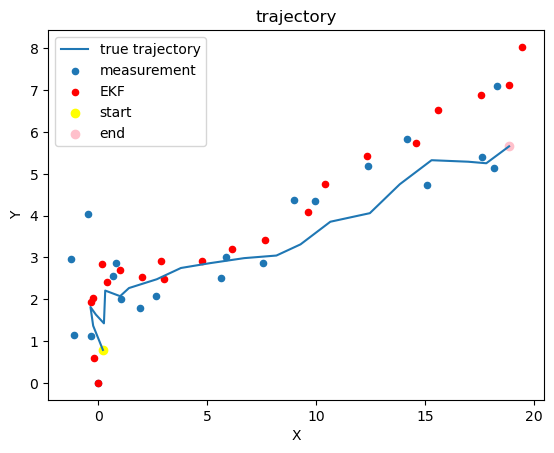

In [213]:
planar = BasePlanarQuadrotor()
lin_bot = LinearBot()


bot = planar

# det_states = generate_true_trajectory(bot,k_N,H,Q,R,k_dt,sigma,x0,k_controls)
# extended = EKF(bot,det_states,k_controls,x0,sigma,Q,H,R,k_N,k_dt)

det_states = generate_true_trajectory(bot,N,H,Q,R,dt,sigma,x0,control_sequence)
extended = EKF(bot,det_states,control_sequence,x0,sigma,Q,H,R,N,dt)

# plot_traj(det_states[0])
plt.plot(det_states[0][:,0],det_states[0][:,2],label = "true trajectory")
plt.scatter(det_states[1][:,0],det_states[1][:,1],label = "measurement", s = 20)  
plt.scatter(extended[:,0],extended[:,2],color = 'red',label = 'EKF',s = 20)

plt.scatter(det_states[0][0,0],det_states[0][0,2],color = 'yellow',label = 'start')
plt.scatter(det_states[0][-1,0],det_states[0][-1,2],color = 'pink',label = 'end')

plt.title('trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

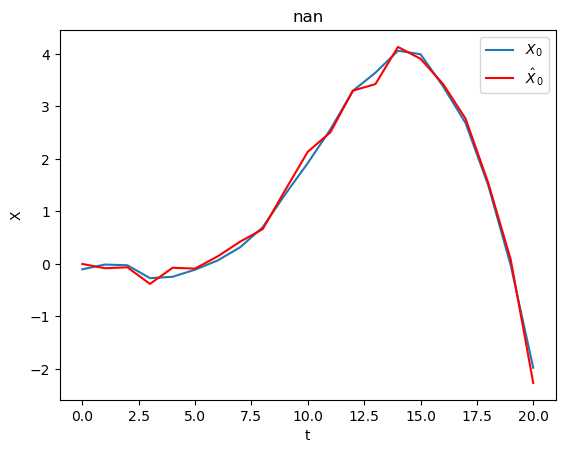

In [98]:
plt.plot(det_states[0][:,0],label = r'$X_0$')
plt.plot(extended[:,0],color = 'red',label = r'$\hat X_0$')

plt.title('nan')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

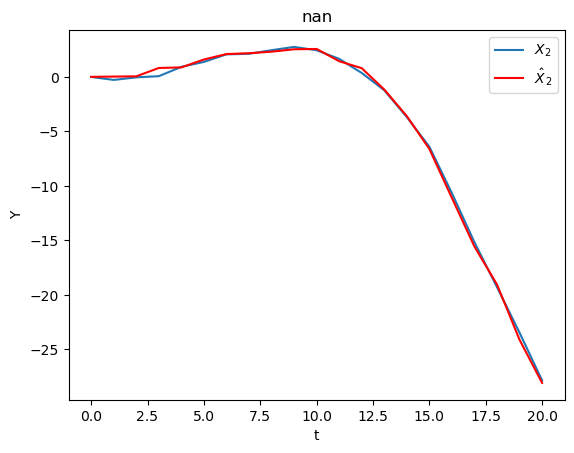

In [79]:
plt.plot(det_states[0][:,2],label = r'$X_2$')
plt.plot(extended[:,2],color = 'red',label = r'$\hat X_2$')


plt.title('nan')
plt.xlabel('t')
plt.ylabel('Y')
plt.legend()
plt.show()

In [160]:
"""

Unscented kalman filter (UKF) localization sample

author: Atsushi Sakai (@Atsushi_twi)

"""
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

# from utils.angle import rot_mat_2d

# Covariance for UKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

#  Simulation parameter
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

DT = 0.1  # time tick [s]
SIM_TIME = 1.0  # simulation time [s]

#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

show_animation = False


def calc_input():
    v = 1.0  # [m/s]
    yawRate = 0.1  # [rad/s]
    u = np.array([[v, yawRate]]).T
    return u


def observation(xTrue, xd, u):
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    # add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2]), 0],
                  [DT * math.sin(x[2]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x


def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z


def generate_sigma_points(xEst, PEst, gamma):
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    n = len(xEst[:, 0])
    # Positive direction
    for i in range(n):
        sigma = np.hstack((sigma, xEst + gamma * Psqrt[:, i:i + 1]))

    # Negative direction
    for i in range(n):
        sigma = np.hstack((sigma, xEst - gamma * Psqrt[:, i:i + 1]))

    return sigma


def predict_sigma_motion(sigma, u):
    """
        Sigma Points prediction with motion model
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = motion_model(sigma[:, i:i + 1], u)

    return sigma


def predict_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    for i in range(sigma.shape[1]):
        sigma[0:2, i] = observation_model(sigma[:, i])

    sigma = sigma[0:2, :]

    return sigma


def calc_sigma_covariance(x, sigma, wc, Pi):
    nSigma = sigma.shape[1]
    d = sigma - x[0:sigma.shape[0]]
    P = Pi
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T

    return P


def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    #  Predict
    sigma = generate_sigma_points(xEst, PEst, gamma)
    print(sigma)
    sigma = predict_sigma_motion(sigma, u)
    xPred = (wm @ sigma.T).T
    PPred = calc_sigma_covariance(xPred, sigma, wc, Q)

    #  Update
    zPred = observation_model(xPred)
    y = z - zPred
    sigma = generate_sigma_points(xPred, PPred, gamma)
    zb = (wm @ sigma.T).T
    z_sigma = predict_sigma_observation(sigma)
    st = calc_sigma_covariance(zb, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)
    K = Pxz @ np.linalg.inv(st)
    xEst = xPred + K @ y
    PEst = PPred - K @ st @ K.T

    return xEst, PEst


def plot_covariance_ellipse(xEst, PEst):  # pragma: no cover
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    fx = rot_mat_2d(angle) @ np.array([x, y])
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")


def setup_ukf(nx):
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calculate weights
    wm = [lamb / (lamb + nx)]
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        wm.append(1.0 / (2 * (nx + lamb)))
        wc.append(1.0 / (2 * (nx + lamb)))
    gamma = math.sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma


In [161]:
nx = 4  # State Vector [x y yaw v]'
xEst = np.zeros((nx, 1))
xTrue = np.zeros((nx, 1))
PEst = np.eye(nx)
xDR = np.zeros((nx, 1))  # Dead reckoning

wm, wc, gamma = setup_ukf(nx)

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

time = 0.0

while SIM_TIME >= time:
    time += DT
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ukf_estimation(xEst, PEst, z, ud, wm, wc, gamma)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    if show_animation:
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(hz[0, :], hz[1, :], ".g")
        plt.plot(np.array(hxTrue[0, :]).flatten(),
                    np.array(hxTrue[1, :]).flatten(), "-b")
        plt.plot(np.array(hxDR[0, :]).flatten(),
                    np.array(hxDR[1, :]).flatten(), "-k")
        plt.plot(np.array(hxEst[0, :]).flatten(),
                    np.array(hxEst[1, :]).flatten(), "-r")
        # plot_covariance_ellipse(xEst, PEst)
        plt.axis("equal")
        plt.grid(True)
        plt.pause(0.001)

[[ 0.     0.002  0.     0.     0.    -0.002  0.     0.     0.   ]
 [ 0.     0.     0.002  0.     0.     0.    -0.002  0.     0.   ]
 [ 0.     0.     0.     0.002  0.     0.     0.    -0.002  0.   ]
 [ 0.     0.     0.     0.     0.002  0.     0.     0.    -0.002]]
[[ 0.11888119  0.12030113  0.11888119  0.11888119  0.11888119  0.11746126
   0.11888119  0.11888119  0.11888119]
 [ 0.06340492  0.06340492  0.06482554  0.06347019  0.06340492  0.06340492
   0.06198429  0.06333964  0.06340492]
 [-0.01214848 -0.01214848 -0.0120832  -0.01015553 -0.01214848 -0.01214848
  -0.01221375 -0.01414143 -0.01214848]
 [ 1.12677711  1.12677711  1.12677711  1.12677711  1.12877711  1.12677711
   1.12677711  1.12677711  1.12477711]]
[[ 0.11020766  0.11137317  0.11020765  0.11020746  0.11020766  0.10904215
   0.11020766  0.11020786  0.11020766]
 [ 0.06020822  0.06020821  0.06137301  0.06023851  0.06020822  0.06020822
   0.05904342  0.06017792  0.06020822]
 [-0.01071395 -0.01071415 -0.01068366 -0.00872073 -0.010